In [29]:
# Install required packages
%pip install grad-cam

# Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.transforms as transforms
from PIL import Image

# Note: If grad-cam doesn't work, you may need to implement GradCAM manually
# or try alternative visualization methods like occlusion sensitivity



Note: you may need to restart the kernel to use updated packages.


In [30]:
import torch
import torch.nn as nn

# Define device for training (MPS for Mac M1/M2, GPU if available, otherwise CPU)
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define a CNN model similar to the provided architecture
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        
        # First convolutional block
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        )
        
        # Second convolutional block
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        )
        
        # Third convolutional block
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        )
        
        # Fourth convolutional block
        self.conv4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        )
        
        # Fifth convolutional block
        self.conv5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        )
        
        # Flatten layer
        self.flatten = nn.Flatten()
        
        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(256 * 7 * 7, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 1)
        )
        
    def forward(self, x):
        # Apply convolutional blocks
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        
        # Handle MPS device issue with adaptive pooling by moving to CPU if needed
        if x.device.type == 'mps':
            # Move to CPU, apply operations, then move back to MPS
            x_cpu = x.to('cpu')
            x_cpu = self.flatten(x_cpu)
            x = x_cpu.to(device)
        else:
            x = self.flatten(x)
            
        # Apply fully connected layers
        x = self.fc(x)
        return x

# Initialize the model
model = CNNModel()
model = model.to(device)

# Load your trained weights (adjust path as needed)
model.load_state_dict(torch.load("pneumonia_cnn_model_15epochs.pth", map_location=device))

# Set model to evaluation mode
model.eval()

print("Model loaded and ready.")

Using device: mps
Model loaded and ready.


In [31]:
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import os

def pad_to_square(image):
    """Pad the image to make it square with zeros around the border."""
    w, h = image.size
    max_dim = max(w, h)
    pad_w = (max_dim - w) // 2
    pad_h = (max_dim - h) // 2
    padding = (pad_w, pad_h, max_dim - w - pad_w, max_dim - h - pad_h)
    return transforms.functional.pad(image, padding, fill=0)

# Custom dataset class for chest X-ray images
class ChestXRayDataset(Dataset):
    def __init__(self, root_dir, class_dirs, transform=None):
        self.filepaths = []
        self.labels = []
        self.transform = transform
        
        # Define label mapping dictionary
        self.label_map = {'NORMAL': 0, 'PNEUMONIA': 1}
        
        # For each class directory, collect all image paths and assign labels
        for class_dir in class_dirs:
            class_path = os.path.join(root_dir, class_dir)
            files = [os.path.join(class_path, f) for f in os.listdir(class_path) if f.endswith(('.jpeg', '.jpg', '.png'))]
            self.filepaths.extend(files)
            self.labels.extend([self.label_map[class_dir]] * len(files))
        
    def __len__(self):
        return len(self.filepaths)
    
    def __getitem__(self, idx):
        img_path = self.filepaths[idx]
        image = Image.open(img_path)
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
            
        return image, torch.tensor(label, dtype=torch.long)

# Define paths for datasets
data_dir = 'data'  # Adjust this to your data directory
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')
test_dir = os.path.join(data_dir, 'test')

# Class directories
class_dirs = ['NORMAL', 'PNEUMONIA']

# Define mean and std values from the training set
mean = [0.34463736414909363, 0.34463736414909363, 0.34463736414909363]
std = [0.28305476903915405, 0.28305476903915405, 0.28305476903915405]

# Define the transform with normalization
transform = transforms.Compose([
    transforms.Lambda(pad_to_square),               # Pad to square
    transforms.Resize((224, 224)),                  # Resize to 224x224
    transforms.Grayscale(num_output_channels=3),    # Convert to 3 channels
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)        # Use training set normalization
])

# Create datasets with the transform
test_dataset = ChestXRayDataset(
    root_dir=test_dir,
    class_dirs=class_dirs,
    transform=transform
)

# Create data loader
test_loader = torch.utils.data.DataLoader(
    test_dataset, 
    batch_size=32,
    shuffle=False
)

print(f"Test dataset size: {len(test_dataset)}")



Test dataset size: 624


In [32]:
# Collect 5 NORMAL and 5 PNEUMONIA images
normal_samples = []
pneumonia_samples = []
normal_indices = []
pneumonia_indices = []

for idx, (img, label) in enumerate(test_dataset):
    if label.item() == 0 and len(normal_samples) < 5:
        normal_samples.append((img, label))
        normal_indices.append(idx)
    elif label.item() == 1 and len(pneumonia_samples) < 5:
        pneumonia_samples.append((img, label))
        pneumonia_indices.append(idx)
    if len(normal_samples) == 5 and len(pneumonia_samples) == 5:
        break

selected_samples = normal_samples + pneumonia_samples
selected_indices = normal_indices + pneumonia_indices
print(f"Selected {len(selected_samples)} samples (5 normal + 5 pneumonia).")
print(f"Normal indices: {normal_indices}")
print(f"Pneumonia indices: {pneumonia_indices}")

Selected 10 samples (5 normal + 5 pneumonia).
Normal indices: [0, 1, 2, 3, 4]
Pneumonia indices: [234, 235, 236, 237, 238]


100%|██████████| 16/16 [00:00<00:00, 59.93it/s]


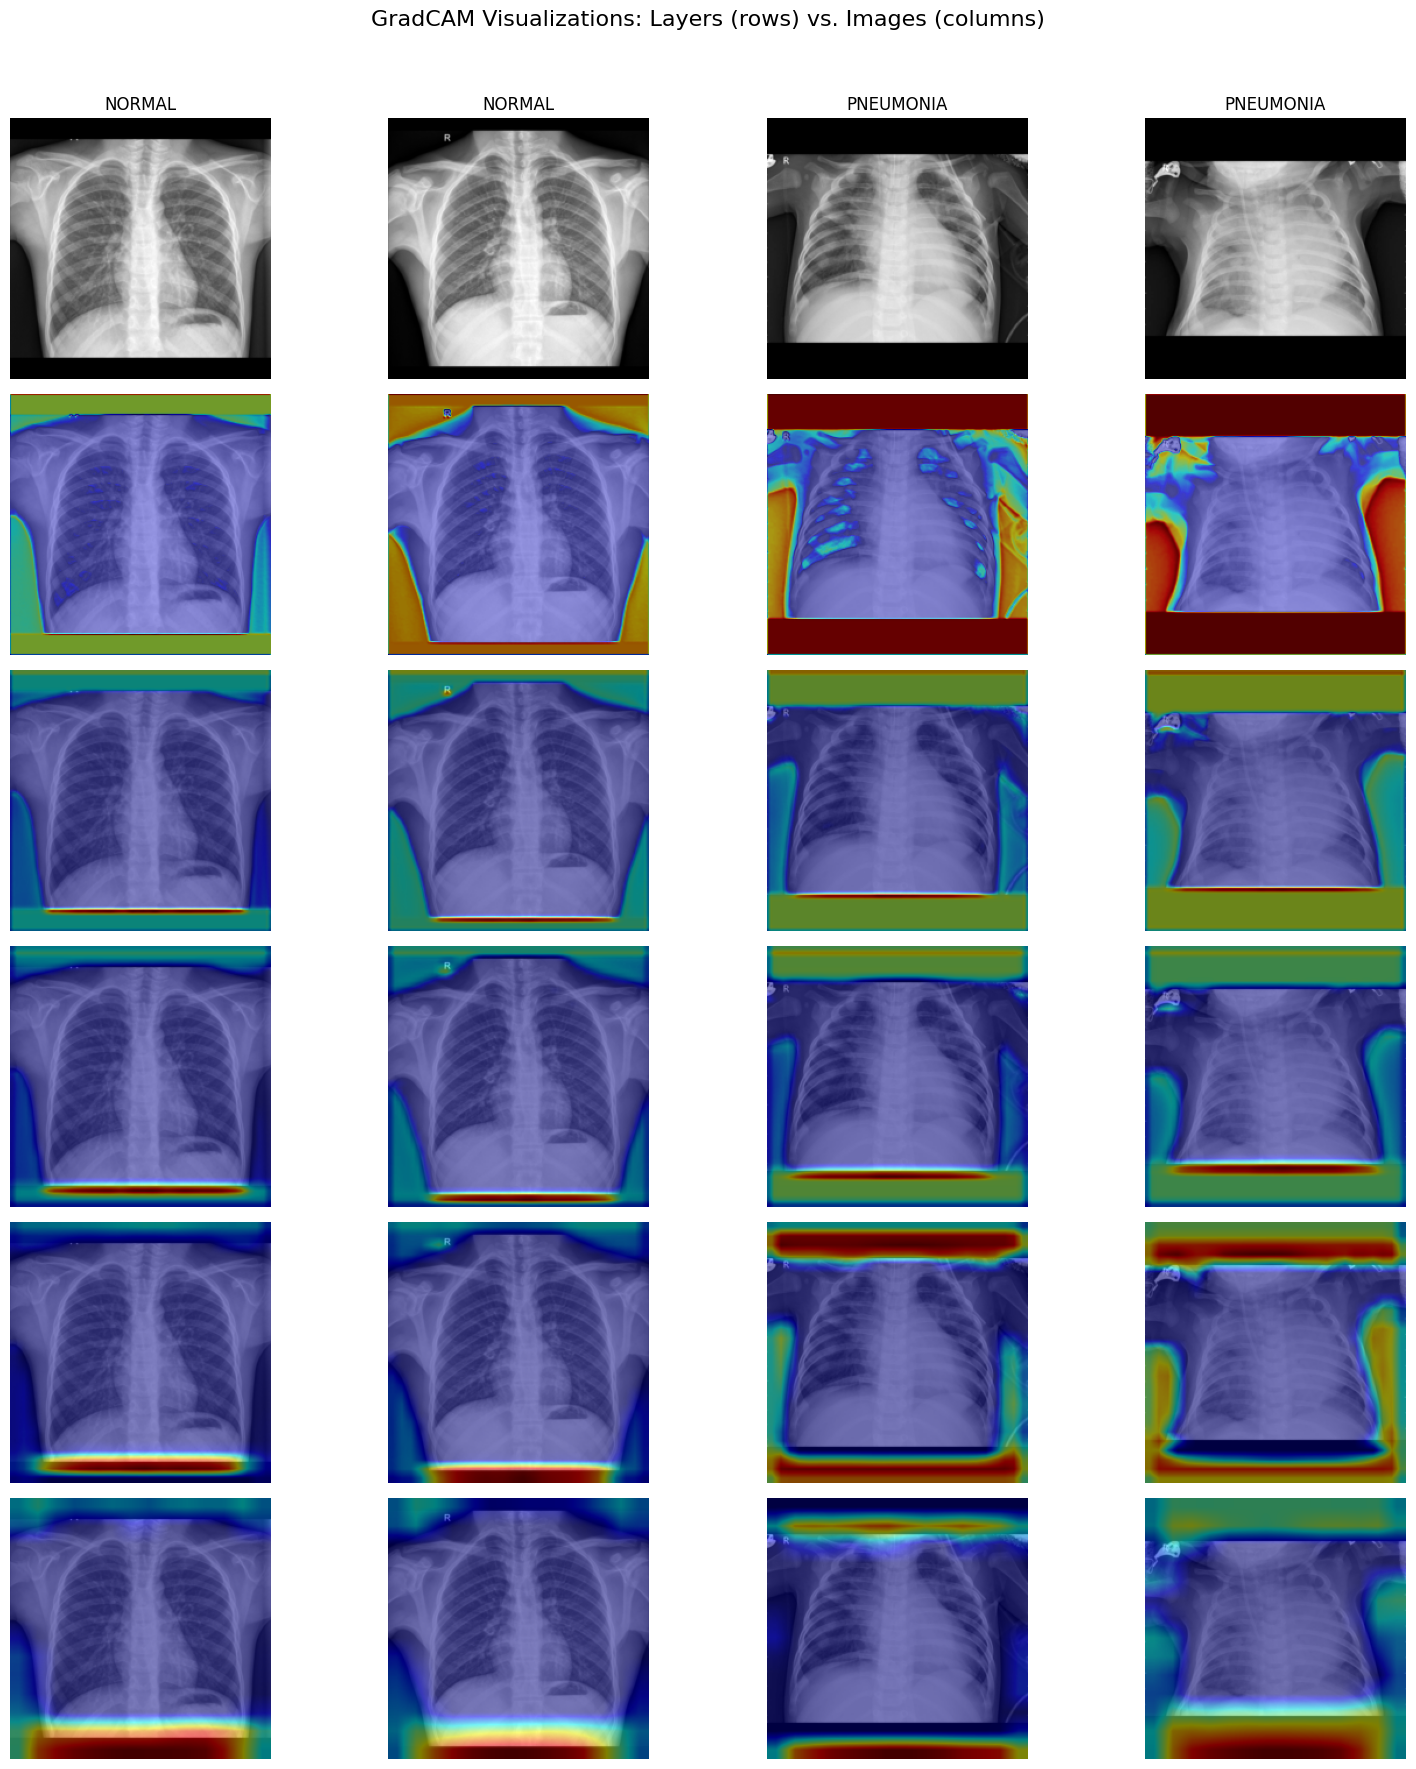

GradCAM Interpretation:
- Bright regions in the heatmap indicate areas that strongly influence the model's prediction
- For PNEUMONIA cases, we expect to see activation in areas with opacities or infiltrates
- For NORMAL cases, the activation might be more diffuse or focused on anatomical structures
- Earlier layers (conv1, conv2) capture more basic features like edges and textures
- Deeper layers (conv4, conv5) capture more complex, class-specific features


In [33]:


# Import necessary libraries for GradCAM
from pytorch_grad_cam import  GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import matplotlib.pyplot as plt
import numpy as np
import torch

# Load the trained CNN model
model.eval()  # Set model to evaluation mode

# Define all target layers for GradCAM visualization
target_layer_groups = {
    "conv1": [model.conv1[0]],  # First conv layer
    "conv2": [model.conv2[0]],  # Second conv layer
    "conv3": [model.conv3[0]],  # Third conv layer
    "conv4": [model.conv4[0]],  # Fourth conv layer
    "conv5": [model.conv5[0]]   # Fifth conv layer
}

# Function to generate and display GradCAM visualizations
def generate_gradcam(model, img_tensor, target_layer):
    # Create a batch dimension
    input_tensor = img_tensor.unsqueeze(0).to(device)
    
    try:
        # Create GradCAM object
        with ScoreCAM(model=model, target_layers=target_layer) as cam:
            # Generate the CAM (without specifying targets to avoid index error)
            grayscale_cam = cam(input_tensor=input_tensor)
            
            # Check if grayscale_cam is not None and has the expected shape
            if grayscale_cam is not None and len(grayscale_cam) > 0:
                grayscale_cam = grayscale_cam[0, :]  # Get the first image in batch
                
                # Convert tensor to numpy for visualization
                img_np = img_tensor.cpu().numpy().transpose(1, 2, 0)
                
                # Normalize image for visualization
                img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())
                
                # Create the CAM visualization
                visualization = show_cam_on_image(img_np, grayscale_cam, use_rgb=True)
                
                return visualization, img_np
            else:
                print(f"GradCAM returned None or empty result for layer {target_layer}")
                return None, None
    except Exception as e:
        print(f"An exception occurred in CAM with layer {target_layer}: {type(e)}. Message: {str(e)}")
        return None, None

# Select samples for visualization (2 normal and 2 pneumonia)
normal_to_show = normal_samples[:2]
pneumonia_to_show = pneumonia_samples[:2]
samples_to_visualize = normal_to_show + pneumonia_to_show

# Create a single figure with layers as rows and images as columns
num_layers = len(target_layer_groups)
num_samples = len(samples_to_visualize)

plt.figure(figsize=(4 * num_samples, 3 * (num_layers + 1)))
plt.suptitle("GradCAM Visualizations: Layers (rows) vs. Images (columns)", fontsize=16)

# First row: original images
for i, (img, label) in enumerate(samples_to_visualize):
    class_name = "NORMAL" if label.item() == 0 else "PNEUMONIA"
    
    # Display original image
    plt.subplot(num_layers + 1, num_samples, i + 1)
    img_np = img.cpu().numpy().transpose(1, 2, 0)
    img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())
    plt.imshow(img_np)
    plt.title(f"{class_name}")
    plt.axis('off')

# Subsequent rows: GradCAM for each layer
for row_idx, (layer_name, target_layers) in enumerate(target_layer_groups.items()):
    for col_idx, (img, label) in enumerate(samples_to_visualize):
        plt.subplot(num_layers + 1, num_samples, (row_idx + 1) * num_samples + col_idx + 1)
        
        # Generate GradCAM visualization
        cam_image, _ = generate_gradcam(model, img, target_layers)
        
        if cam_image is not None:
            plt.imshow(cam_image)
            if col_idx == 0:  # Only add layer name to the first column
                plt.ylabel(layer_name, fontsize=12)
        else:
            plt.text(0.5, 0.5, "Failed", horizontalalignment='center', verticalalignment='center')
        plt.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust for the suptitle
plt.show()

# Print interpretation
print("GradCAM Interpretation:")
print("- Bright regions in the heatmap indicate areas that strongly influence the model's prediction")
print("- For PNEUMONIA cases, we expect to see activation in areas with opacities or infiltrates")
print("- For NORMAL cases, the activation might be more diffuse or focused on anatomical structures")
print("- Earlier layers (conv1, conv2) capture more basic features like edges and textures")
print("- Deeper layers (conv4, conv5) capture more complex, class-specific features")


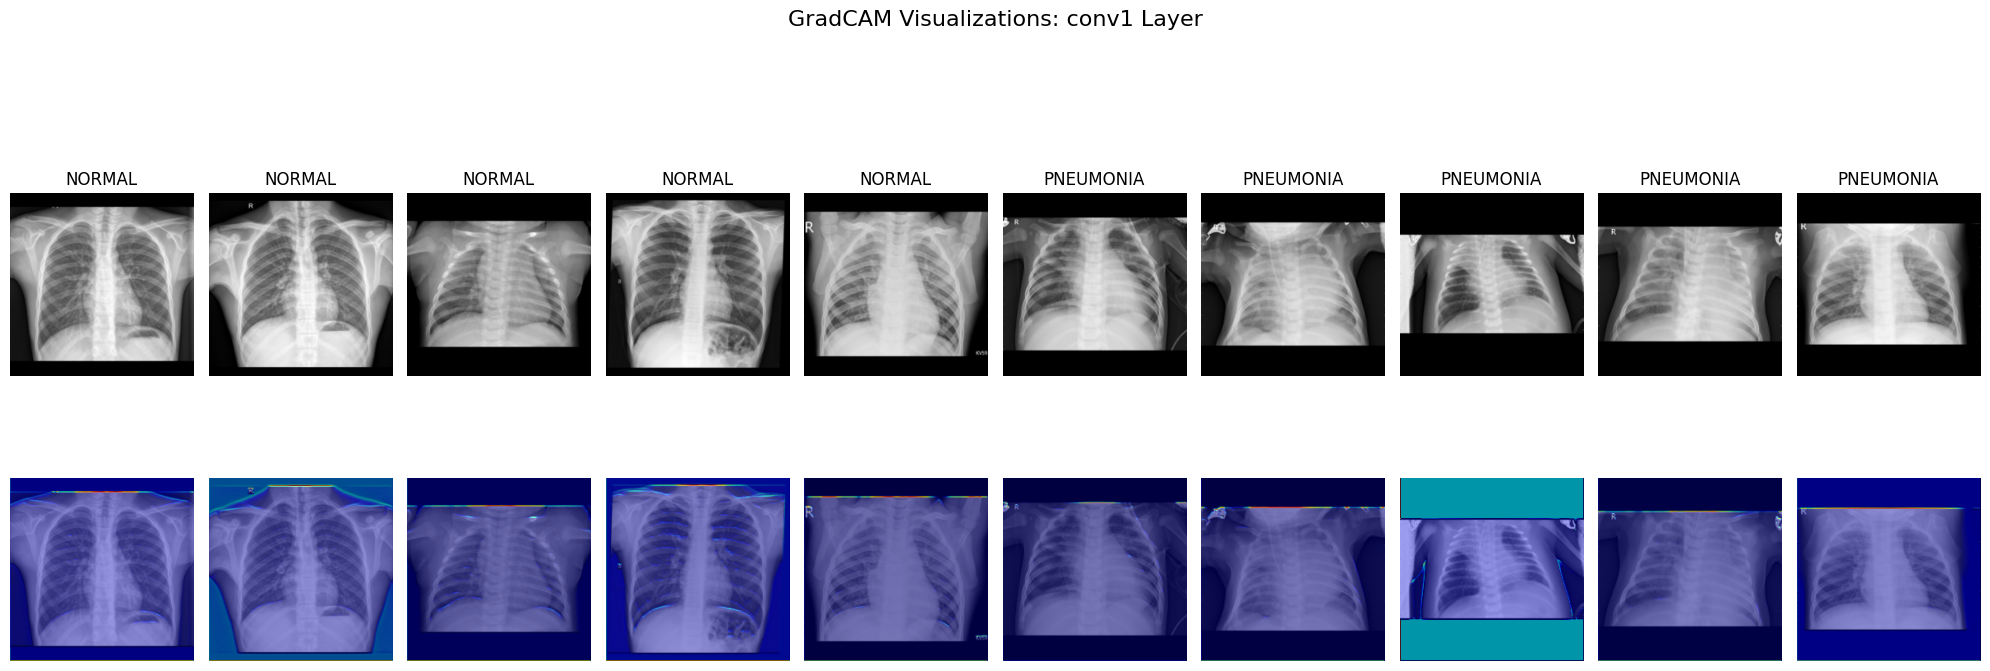

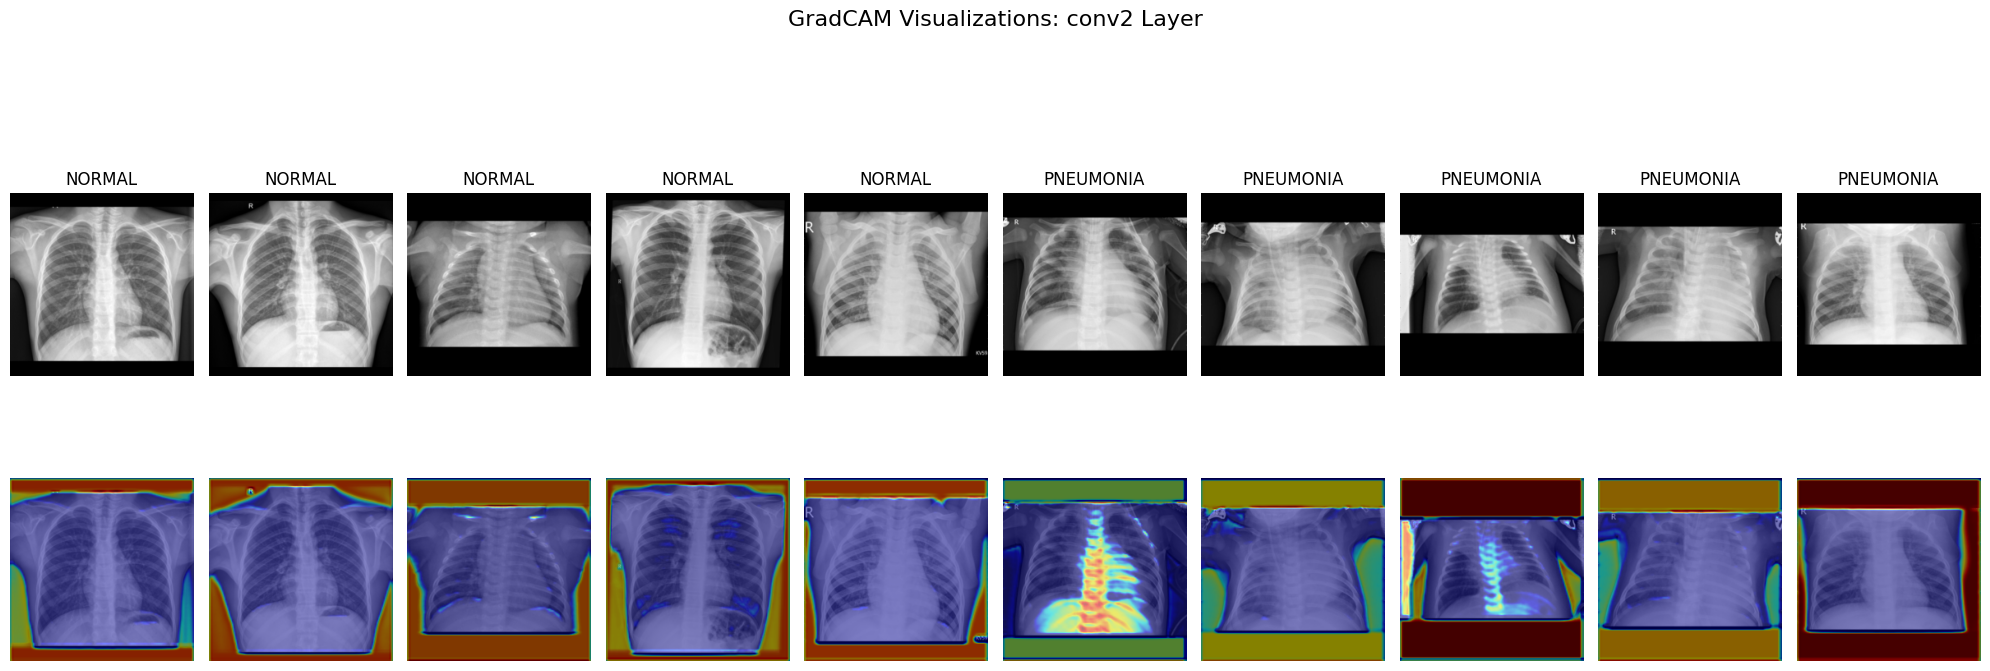

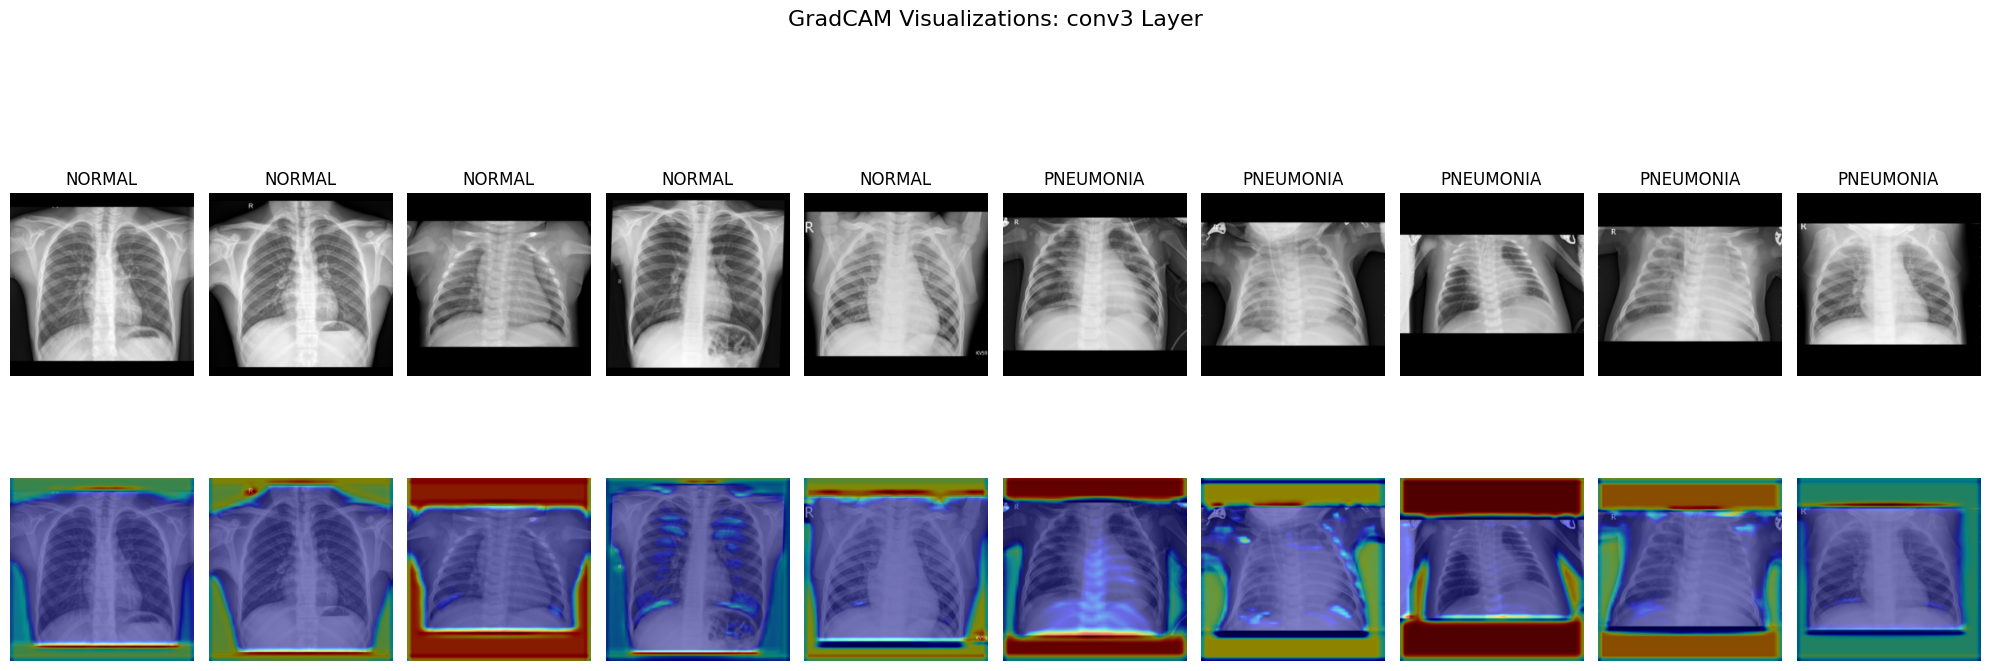

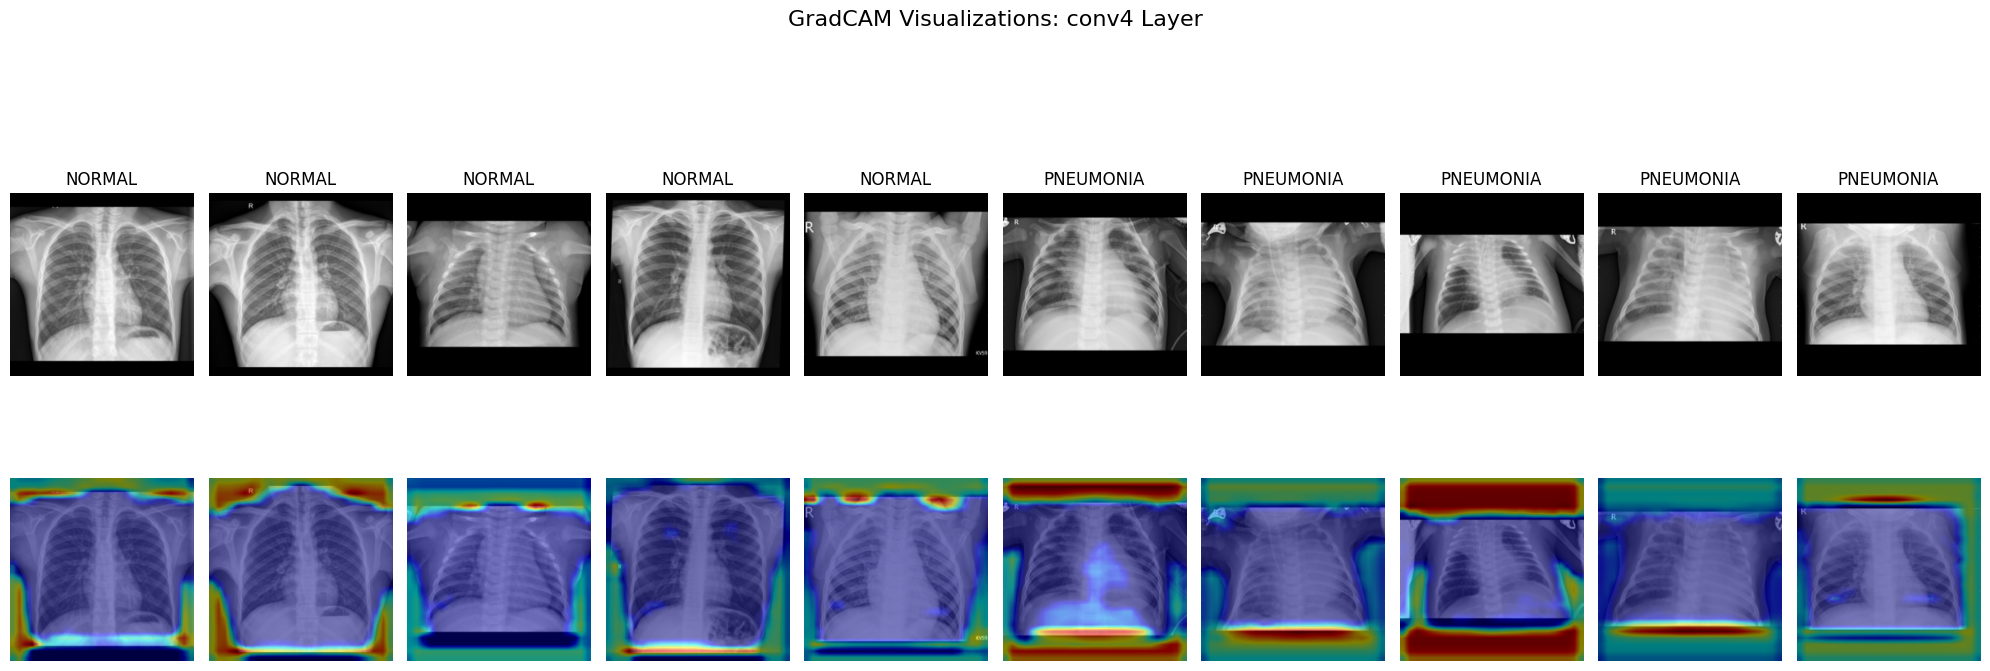

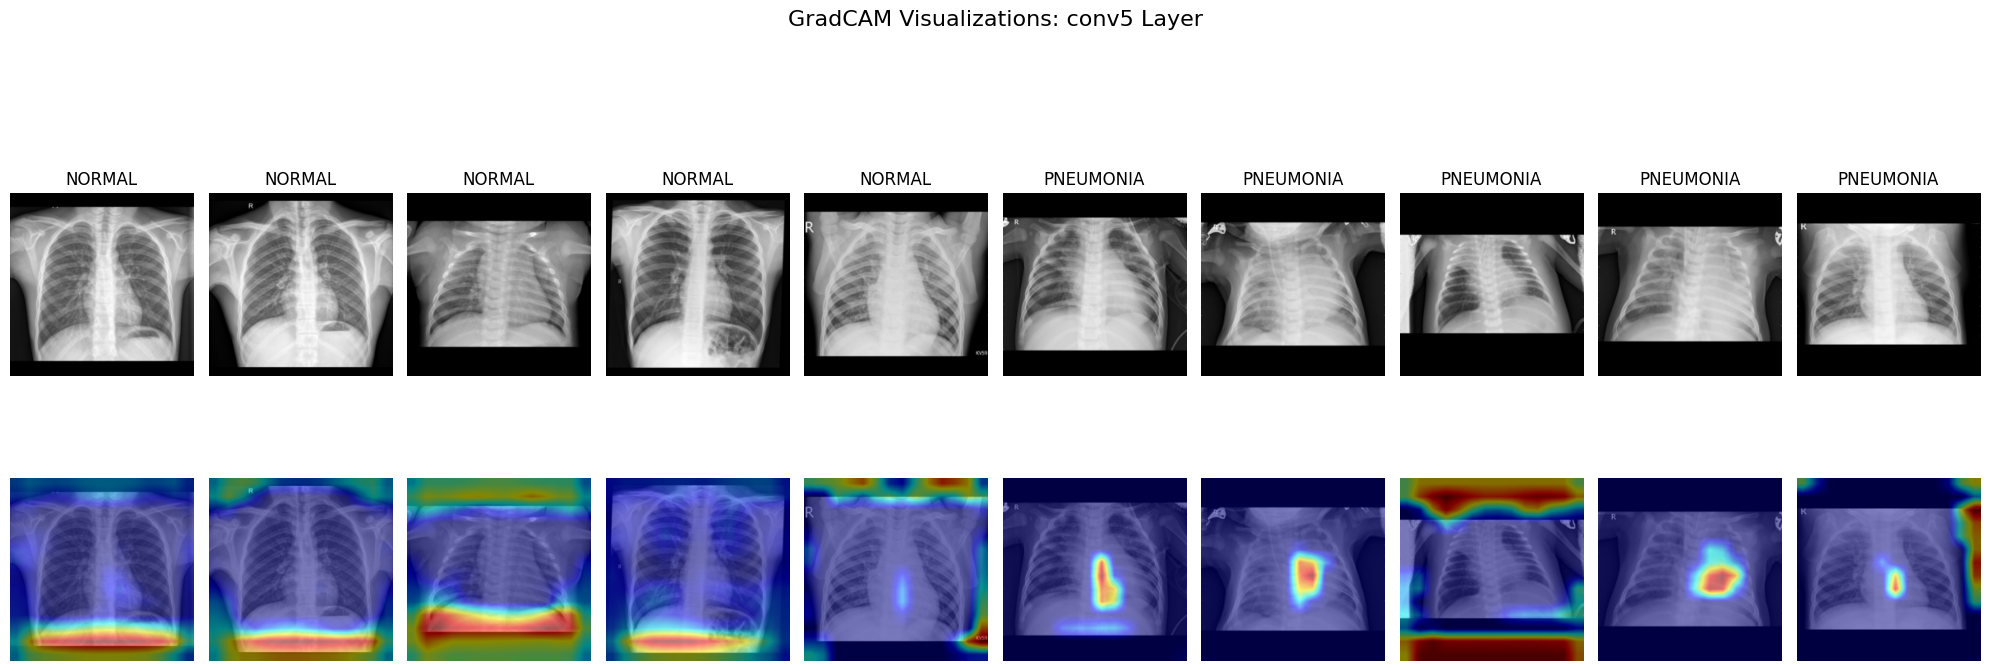

GradCAM Interpretation:
- Bright regions in the heatmap indicate areas that strongly influence the model's prediction
- For PNEUMONIA cases, we expect to see activation in areas with opacities or infiltrates
- For NORMAL cases, the activation might be more diffuse or focused on anatomical structures
- Earlier layers (conv1, conv2) capture more basic features like edges and textures
- Deeper layers (conv4, conv5) capture more complex, class-specific features


In [37]:
# Import necessary libraries for GradCAM
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import matplotlib.pyplot as plt
import numpy as np
import torch

# Load the trained CNN model
model.eval()  # Set model to evaluation mode

# Define all target layers for GradCAM visualization
target_layer_groups = {
    "conv1": [model.conv1[0]],  # First conv layer
    "conv2": [model.conv2[0]],  # Second conv layer
    "conv3": [model.conv3[0]],  # Third conv layer
    "conv4": [model.conv4[0]],  # Fourth conv layer
    "conv5": [model.conv5[0]]   # Fifth conv layer
}

# Function to generate and display GradCAM visualizations
def generate_gradcam(model, img_tensor, target_layer):
    # Create a batch dimension
    input_tensor = img_tensor.unsqueeze(0).to(device)
    
    try:
        # Create GradCAM object
        with GradCAM(model=model, target_layers=target_layer) as cam:
            # Generate the CAM (without specifying targets to avoid index error)
            grayscale_cam = cam(input_tensor=input_tensor)
            
            # Check if grayscale_cam is not None and has the expected shape
            if grayscale_cam is not None and len(grayscale_cam) > 0:
                grayscale_cam = grayscale_cam[0, :]  # Get the first image in batch
                
                # Convert tensor to numpy for visualization
                img_np = img_tensor.cpu().numpy().transpose(1, 2, 0)
                
                # Normalize image for visualization
                img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())
                
                # Create the CAM visualization
                visualization = show_cam_on_image(img_np, grayscale_cam, use_rgb=True)
                
                return visualization, img_np
            else:
                print(f"GradCAM returned None or empty result for layer {target_layer}")
                return None, None
    except Exception as e:
        print(f"An exception occurred in CAM with layer {target_layer}: {type(e)}. Message: {str(e)}")
        return None, None

# Select samples for visualization (5 normal and 5 pneumonia)
normal_to_show = normal_samples[:5]
pneumonia_to_show = pneumonia_samples[:5]
samples_to_visualize = normal_to_show + pneumonia_to_show

# Generate 5 plots, one for each layer
for layer_name, target_layers in target_layer_groups.items():
    plt.figure(figsize=(20, 8))
    plt.suptitle(f"GradCAM Visualizations: {layer_name} Layer", fontsize=16)
    
    # Create a 2x10 grid (2 rows, 10 columns)
    # First row: original images
    # Second row: GradCAM visualizations
    
    # Display all samples
    for i, (img, label) in enumerate(samples_to_visualize):
        class_name = "NORMAL" if label.item() == 0 else "PNEUMONIA"
        
        # Display original image in the first row
        plt.subplot(2, 10, i + 1)
        img_np = img.cpu().numpy().transpose(1, 2, 0)
        img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())
        plt.imshow(img_np)
        plt.title(f"{class_name}")
        plt.axis('off')
        
        # Display GradCAM in the second row
        plt.subplot(2, 10, i + 11)
        cam_image, _ = generate_gradcam(model, img, target_layers)
        
        if cam_image is not None:
            plt.imshow(cam_image)
        else:
            plt.text(0.5, 0.5, "Failed", horizontalalignment='center', verticalalignment='center')
        plt.axis('off')
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust for the suptitle
    plt.show()

# Print interpretation
print("GradCAM Interpretation:")
print("- Bright regions in the heatmap indicate areas that strongly influence the model's prediction")
print("- For PNEUMONIA cases, we expect to see activation in areas with opacities or infiltrates")
print("- For NORMAL cases, the activation might be more diffuse or focused on anatomical structures")
print("- Earlier layers (conv1, conv2) capture more basic features like edges and textures")
print("- Deeper layers (conv4, conv5) capture more complex, class-specific features")
